In [7]:
# Basic setup
import pandas as pd
import numpy as np
import os
import random
import numpy as np
import torch

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and scaling
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# For handling warnings and display
import warnings
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Universal reproducibility seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Paths to your dataset
BASE_PATH = "IEEE Primary Data"
TRANS_PATH = os.path.join(BASE_PATH, "train_transaction.csv")
ID_PATH = os.path.join(BASE_PATH, "train_identity.csv")


In [9]:
# Load datasets
transaction = pd.read_csv(TRANS_PATH)
identity = pd.read_csv(ID_PATH)

print("Transaction shape:", transaction.shape)
print("Identity shape:", identity.shape)

# Merge on TransactionID
df = transaction.merge(identity, on='TransactionID', how='left')
print("Merged shape:", df.shape)

# Inspect target distribution
print("\nTarget distribution (isFraud):")
print(df['isFraud'].value_counts(normalize=True))


Transaction shape: (590540, 394)
Identity shape: (144233, 41)
Merged shape: (590540, 434)

Target distribution (isFraud):
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


In [10]:
# Percentage of missing values
missing = df.isnull().mean().sort_values(ascending=False)
missing_summary = missing[missing > 0.4]
print("Columns with >40% missing values:\n", missing_summary)

# Drop columns with more than 90% missing values
drop_cols = missing[missing > 0.9].index
df.drop(columns=drop_cols, inplace=True)
print(f"Dropped {len(drop_cols)} highly missing columns.")

# Fill numeric columns with median and categorical with 'missing'
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna('missing', inplace=True)


Columns with >40% missing values:
 id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
           ...   
V1       0.472935
M2       0.459071
M3       0.459071
M1       0.459071
D3       0.445149
Length: 232, dtype: float64
Dropped 12 highly missing columns.


In [11]:
# Identify categorical features
categorical_cols = df.select_dtypes(include='object').columns

# Apply Label Encoding for categorical variables
le = LabelEncoder()
for col in categorical_cols:
    try:
        df[col] = le.fit_transform(df[col])
    except:
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])

print(f"Encoded {len(categorical_cols)} categorical columns.")


Encoded 29 categorical columns.


In [12]:
# Separate target variable
y = df['isFraud']
X = df.drop(columns=['isFraud', 'TransactionID'])

# Standard scaling for numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Rebuild dataframe
X = pd.DataFrame(X_scaled, columns=X.columns)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data: {X_train.shape}")
print(f"Testing data: {X_test.shape}")


Training data: (472432, 420)
Testing data: (118108, 420)


In [14]:
# Create output directories if needed
os.makedirs("Processed", exist_ok=True)

# Save preprocessed data
train_preprocessed = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_preprocessed = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

train_preprocessed.to_csv("Processed/train_preprocessed.csv", index=False)
test_preprocessed.to_csv("Processed/test_preprocessed.csv", index=False)

print("✅ Preprocessed data saved to 'Processed/' directory.")


✅ Preprocessed data saved to 'Processed/' directory.


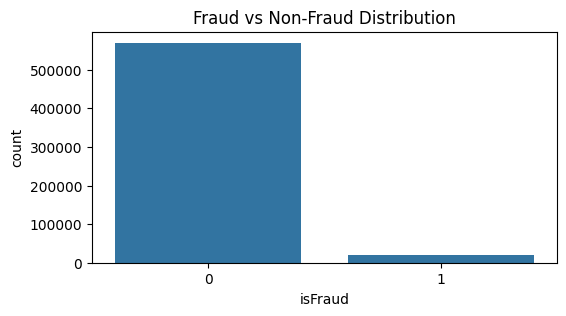

Top 15 correlated features with target:
 isFraud    1.000000
V26        0.006019
V208       0.004729
V223       0.004611
D12        0.004375
V25        0.004371
D9         0.003958
V252       0.003871
V108       0.003777
V82        0.003744
V83        0.003744
V270       0.003704
V274       0.003636
V118       0.003606
V253       0.003577
Name: isFraud, dtype: float64


In [15]:
# Quick check of feature correlations and class imbalance
plt.figure(figsize=(6, 3))
sns.countplot(x=y)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

# Feature correlation heatmap (subset)
corr = train_preprocessed.corr()['isFraud'].abs().sort_values(ascending=False)[:15]
print("Top 15 correlated features with target:\n", corr)


In [16]:
real_fraud = pd.read_csv("Processed/train_preprocessed.csv")

In [17]:
target = "isFraud"
features = [col for col in real_fraud.columns if col != target]


In [18]:
real_fraud[features].isnull().sum()[real_fraud[features].isnull().sum() > 0]


TransactionDT     94372
TransactionAmt    94372
ProductCD         94372
card1             94372
card2             94372
                  ...  
id_36             94372
id_37             94372
id_38             94372
DeviceType        94372
DeviceInfo        94372
Length: 420, dtype: int64

In [19]:
# Drop columns that are mostly missing
real_fraud.dropna(thresh=int(0.05 * len(real_fraud)), axis=1, inplace=True)


In [20]:
# Fill missing numeric columns with median and categorical with mode
for col in real_fraud[features].columns:
    if real_fraud[col].dtype in ['float64', 'int64']:
        real_fraud[col].fillna(real_fraud[col].median(), inplace=True)
    else:
        real_fraud[col].fillna(real_fraud[col].mode()[0], inplace=True)


In [21]:
print("Any NaNs left?", real_fraud[features].isnull().any().any())


Any NaNs left? False


In [22]:
import numpy as np

print("NaNs left:", real_fraud[features].isnull().any().any())
print("Infinite values:", np.isinf(real_fraud[features]).any().any())
print("Dataset shape:", real_fraud[features].shape)


NaNs left: False
Infinite values: False
Dataset shape: (566804, 420)


In [23]:
real_fraud.replace([np.inf, -np.inf], np.nan, inplace=True)
real_fraud.dropna(inplace=True)


In [24]:
# Detect discrete (categorical) columns — usually integer-encoded or with few unique values
discrete_columns = [col for col in real_fraud.columns if real_fraud[col].nunique() < 25]

print(f"Detected {len(discrete_columns)} discrete columns:")
print(discrete_columns[:10])  # show a few


Detected 199 discrete columns:
['ProductCD', 'card4', 'card6', 'C3', 'D9', 'M1', 'M2', 'M3', 'M4', 'M5']


In [25]:
# Clean copy for CTGAN
ctgan_data = real_fraud[features].replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print("✅ Clean CTGAN dataset shape:", ctgan_data.shape)


✅ Clean CTGAN dataset shape: (472432, 420)


In [26]:
# Ensure the target column isn't in the data or discrete columns
if 'isFraud' in ctgan_data.columns:
    ctgan_data = ctgan_data.drop(columns=['isFraud'])

if 'isFraud' in discrete_columns:
    discrete_columns.remove('isFraud')

print("✅ 'isFraud' removed from both training data and discrete column list.")


✅ 'isFraud' removed from both training data and discrete column list.


In [ ]:
from sdv.single_table.ctgan import CTGAN

ctgan = CTGAN(epochs=100, batch_size=500, verbose=True)
ctgan.random_state = SEED
ctgan.fit(ctgan_data, discrete_columns=discrete_columns)
print("✅ CTGAN training completed successfully.")




In [ ]:
synthetic = ctgan.sample(5)
print("Synthetic data sample:")
display(synthetic.head())


In [ ]:
# Number of synthetic samples to create
n_samples = 10000  # adjust depending on your target fraud ratio

synthetic_fraud = ctgan.sample(n_samples)

# Tag the generated samples as fraudulent
synthetic_fraud['isFraud'] = 1

print("Synthetic Fraud Data Preview:")
display(synthetic_fraud.head())

print("Synthetic dataset shape:", synthetic_fraud.shape)


In [ ]:
import os
os.makedirs("Synthetic", exist_ok=True)
synthetic_fraud.to_csv("Synthetic/synthetic_fraud.csv", index=False)
print("✅ Synthetic fraud data saved successfully.")


In [ ]:
from scipy.stats import ks_2samp, wasserstein_distance

def validate_similarity(real_df, synth_df, cols):
    results = []
    for col in cols:
        if col in real_df.columns and np.issubdtype(real_df[col].dtype, np.number):
            ks_stat, ks_p = ks_2samp(real_df[col], synth_df[col])
            ws_dist = wasserstein_distance(real_df[col], synth_df[col])
            results.append((col, ks_stat, ks_p, ws_dist))
    return pd.DataFrame(results, columns=['Feature', 'KS_Statistic', 'p_value', 'Wasserstein_Distance'])

validation_results = validate_similarity(real_fraud, synthetic_fraud, real_fraud.columns)
display(validation_results.sort_values('KS_Statistic').head(10))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ['TransactionAmt', 'card1', 'addr1']  # adjust as relevant

for col in features_to_plot:
    plt.figure(figsize=(6,3))
    sns.kdeplot(real_fraud[col], label="Real Fraud", fill=True)
    sns.kdeplot(synthetic_fraud[col], label="Synthetic Fraud", fill=True)
    plt.title(f"Distribution Comparison: {col}")
    plt.legend()
    plt.show()


In [ ]:
# ============================================================
# FRAUDGEN SYNTHETIC DATA VALIDATION SYSTEM
# ============================================================
# Author: FraudGen Project Team
# Stage: Synthetic Data Validation and Quality Assessment
# ============================================================

import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load real and synthetic datasets
real_fraud = pd.read_csv("Processed/train_preprocessed.csv")
synthetic_fraud = pd.read_csv("Synthetic/synthetic_fraud.csv")
real_test = pd.read_csv("Processed/test_preprocessed.csv")

target = 'isFraud'
real_fraud = real_fraud[real_fraud[target] == 1]  # Only fraudulent class

# Common columns between real and synthetic
common_cols = list(set(real_fraud.columns) & set(synthetic_fraud.columns))
common_cols = [c for c in common_cols if c != target]

print(f"🧩 Validation on {len(common_cols)} overlapping features.")

# Clean numeric data before computing MMD
numeric_cols = [c for c in common_cols if np.issubdtype(real_fraud[c].dtype, np.number)]

# Fill or drop NaNs for numeric columns
real_clean = real_fraud[numeric_cols].copy()
synthetic_clean = synthetic_fraud[numeric_cols].copy()

# Option 1: Fill NaNs with median (recommended for numeric stability)
real_clean = real_clean.fillna(real_clean.median())
synthetic_clean = synthetic_clean.fillna(synthetic_clean.median())

# Option 2: Drop any remaining NaN rows (if tiny fraction)
real_clean = real_clean.dropna()
synthetic_clean = synthetic_clean.dropna()

# ============================================================
# 🔧 CLEAN AND PREPARE NUMERIC DATA FOR MMD VALIDATION
# ============================================================

# 1️⃣ Identify numeric columns safely
numeric_cols = [
    c for c in common_cols
    if np.issubdtype(real_fraud[c].dtype, np.number)
]

# 2️⃣ Create numeric copies
real_clean = real_fraud[numeric_cols].copy()
synthetic_clean = synthetic_fraud[numeric_cols].copy()

# 3️⃣ Convert all to numeric (coerce errors → NaN)
real_clean = real_clean.apply(pd.to_numeric, errors='coerce')
synthetic_clean = synthetic_clean.apply(pd.to_numeric, errors='coerce')

# 4️⃣ Replace inf / -inf with NaN
real_clean = real_clean.replace([np.inf, -np.inf], np.nan)
synthetic_clean = synthetic_clean.replace([np.inf, -np.inf], np.nan)

# 5️⃣ Fill NaN values with median (robust against skew)
real_clean = real_clean.fillna(real_clean.median())
synthetic_clean = synthetic_clean.fillna(synthetic_clean.median())

# 6️⃣ Drop columns still containing any NaNs (very rare)
nan_cols_real = real_clean.columns[real_clean.isna().any()].tolist()
nan_cols_synth = synthetic_clean.columns[synthetic_clean.isna().any()].tolist()
nan_cols = list(set(nan_cols_real + nan_cols_synth))
if nan_cols:
    print(f"⚠️ Dropping columns with persistent NaNs: {nan_cols}")
    real_clean = real_clean.drop(columns=nan_cols, errors="ignore")
    synthetic_clean = synthetic_clean.drop(columns=nan_cols, errors="ignore")

# 7️⃣ Sample for MMD
sample_n = min(2000, len(real_clean), len(synthetic_clean))
Xr = real_clean.sample(n=sample_n, random_state=42).values
Xs = synthetic_clean.sample(n=sample_n, random_state=42).values

print(f"✅ Clean numeric samples: Real {Xr.shape}, Synthetic {Xs.shape}")
print(f"Remaining NaNs in real: {np.isnan(Xr).any()}, synthetic: {np.isnan(Xs).any()}")

# ============================================================
# 3️⃣ CLASSIFIER TWO-SAMPLE TEST (CTST)
# ============================================================

X_real = real_fraud[common_cols].values
X_synth = synthetic_fraud[common_cols].values

X = np.vstack([X_real, X_synth])
y = np.hstack([np.zeros(len(X_real)), np.ones(len(X_synth))])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(Xtr, ytr)
probs = clf.predict_proba(Xte)[:, 1]
auc = roc_auc_score(yte, probs)

print(f"Classifier Two-Sample Test AUC: {auc:.3f}")
if auc <= 0.6:
    print("✅ Real and synthetic data are statistically indistinguishable.")
else:
    print("⚠️ Synthetic data may differ noticeably from real distributions.")

# ============================================================
# 4️⃣ CORRELATION MATRIX DIFFERENCE
# ============================================================

corr_real = real_fraud[common_cols].corr().values
corr_synth = synthetic_fraud[common_cols].corr().values
corr_diff = np.linalg.norm(corr_real - corr_synth, 'fro')
print(f"Correlation Matrix Frobenius Norm Difference: {corr_diff:.3f}")

# ============================================================
# 5️⃣ NEAREST-NEIGHBOR PRIVACY / NOVELTY CHECK
# ============================================================

nbrs = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(Xr)
distances, _ = nbrs.kneighbors(Xs)
mean_nn, min_nn = distances.mean(), distances.min()

print(f"Mean synth→real NN distance: {mean_nn:.4f}")
print(f"Min synth→real NN distance:  {min_nn:.8f}")

if min_nn < 1e-6:
    print("⚠️ Warning: potential memorization detected (near-duplicate samples).")
else:
    print("✅ No near-duplicates found. Privacy preserved.")

# ============================================================
# 6️⃣ TRAIN-ON-SYNTH, TEST-ON-REAL (TSTR)
# ============================================================

augmented_df = pd.read_csv("Synthetic/synthetic_fraud.csv")

feat_cols = [c for c in augmented_df.columns if c != target and c in real_test.columns]
X_synth = augmented_df[feat_cols]
y_synth = augmented_df[target]
X_real = real_test[feat_cols]
y_real = real_test[target]

tstr_model = RandomForestClassifier(n_estimators=200, random_state=42)
tstr_model.fit(X_synth, y_synth)
y_pred = tstr_model.predict(X_real)

f1 = f1_score(y_real, y_pred)
prec = precision_score(y_real, y_pred)
rec = recall_score(y_real, y_pred)

print(f"TSTR Evaluation (Train synthetic, Test real):")
print(f"F1: {f1:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}")

# ============================================================
# 7️⃣ VISUALIZATION (OPTIONAL)
# ============================================================

features_to_plot = ['TransactionAmt', 'card1', 'addr1']  # adjust as relevant
for col in features_to_plot:
    if col in real_fraud.columns:
        plt.figure(figsize=(6,3))
        sns.kdeplot(real_fraud[col], label="Real Fraud", fill=True)
        sns.kdeplot(synthetic_fraud[col], label="Synthetic Fraud", fill=True)
        plt.title(f"Distribution Comparison: {col}")
        plt.legend()
        plt.show()

# ============================================================
# 8️⃣ FINAL SUMMARY REPORT
# ============================================================

validation_summary = {
    "Mean_KS_p": ks_mean_p,
    "Mean_Wasserstein": ws_mean,
    "MMD": mmd_val,
    "CTST_AUC": auc,
    "Corr_Frobenius": corr_diff,
    "NN_Mean": mean_nn,
    "NN_Min": min_nn,
    "TSTR_F1": f1,
    "TSTR_Precision": prec,
    "TSTR_Recall": rec
}

summary_df = pd.DataFrame([validation_summary])
os.makedirs("Reports", exist_ok=True)
summary_df.to_csv("Reports/synthetic_data_validation_summary.csv", index=False)

print("\n📊 VALIDATION SUMMARY SAVED → 'Reports/synthetic_data_validation_summary.csv'")
display(summary_df)
